In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter

# Section 1 - EDA

### Number of records and attributes

In [55]:
data = pd.read_csv('/Users/aditi/Documents/Spring_24/Data_Mining/Project/data/orders_train.txt', sep=';')
print('Number of records between {} to {}: {}'.format(data['orderDate'].iloc[0], data['orderDate'].iloc[-1], len(data)))
print('Number of attributes corresponding to a single record {}:'.format(data.shape[1]-1))
data.head()



Number of records between 2014-01-01 to 2015-09-30: 2325165
Number of attributes corresponding to a single record 14:


,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.00,29.99,0,0.0,c1010575,2,BPRG,0
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.00,39.99,0,0.0,c1010575,2,BPRG,0
2,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.00,49.99,0,0.0,c1045905,4,BPRG,0
3,a1000002,2014-01-01,i1001999,1992,38,8.0,1,49.99,49.99,0,0.0,c1045905,4,BPRG,1
4,a1000003,2014-01-01,i1001942,1968,42,8.0,1,10.00,35.99,0,0.0,c1089295,2,PAYPALVC,0


### Data types and statistics

In [56]:
# date in YYYY-MM-DD
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325165 entries, 0 to 2325164
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   orderID         object 
 1   orderDate       object 
 2   articleID       object 
 3   colorCode       int64  
 4   sizeCode        object 
 5   productGroup    float64
 6   quantity        int64  
 7   price           float64
 8   rrp             float64
 9   voucherID       object 
 10  voucherAmount   float64
 11  customerID      object 
 12  deviceID        int64  
 13  paymentMethod   object 
 14  returnQuantity  int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 266.1+ MB
None


### Missing values and improper records

In [57]:
#check NA values
print(data.isna().sum())
#drop NA values since not a significant number of records contain NA
data = data.dropna()

print(data.shape)

orderID             0
orderDate           0
articleID           0
colorCode           0
sizeCode            0
productGroup      351
quantity            0
price               0
rrp               351
voucherID           6
voucherAmount       0
customerID          0
deviceID            0
paymentMethod       0
returnQuantity      0
dtype: int64
(2324812, 15)


In [58]:
# records with 
data = data.rename(columns={'price':'orderPrice', 'rrp':'retailPrice'})
drop_idx = data[(data['quantity']==0) |  (data['orderPrice']==0) | (data['quantity']<data['returnQuantity']) ].index
data = data.drop(drop_idx)
data.shape

(2277968, 15)

In [ ]:
data.groupby('orderID')[['quantity',  'orderPrice', 'returnQuantity']].sum().describe().iloc[1:, :]

### Temporal Analysis

In [ ]:
data[['year', 'month', 'day']] = data['orderDate'].str.split('-', expand=True)

In [ ]:
monthlySale = data.groupby(['month', 'day', 'year'])['quantity'].sum().reset_index()

In [ ]:
plt.figure(figsize=(14, 8))
sns.swarmplot(x='month', y='quantity', data=monthlySale, hue = 'year', dodge=True)
sns.boxplot(x='month', y='quantity', data=monthlySale, hue = 'year', dodge=True)
plt.show()

In [ ]:
monthlyReturn = data.groupby(['month', 'day', 'year'])['returnQuantity'].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.swarmplot(x='month', y='returnQuantity', data=monthlyReturn, hue = 'year', dodge=True)
sns.boxplot(x='month', y='returnQuantity', data=monthlyReturn, hue = 'year')
plt.show()

### Return rate analysis

In [ ]:
#return rate by quantity
rrq = data['returnQuantity'].sum()/data['quantity'].sum()
print(rrq)
#return rate by order
rro= data[data['returnQuantity']>0].shape[0]/data[data['quantity']>0].shape[0]
print(rro)

### Univariate analysis

#### Sizes offered by the retailer

In [ ]:
sizes = data['sizeCode'].value_counts()
sns.barplot(x= sizes.index, y=sizes.values, hue = sizes.index)
plt.xticks(rotation=45)
plt.ylabel('quantity')
plt.show()

#### Sizes bought as a function of unique customers

In [ ]:
# dropping sizes A and I for now...
data = data[~data['sizeCode'].isin(['A', 'I'])]
# custm_size = data.groupby('customerID')['sizeCode'].agg(list).reset_index()
custm_size = data.groupby('customerID')['sizeCode'].agg(list).reset_index()

custm_size['sizeCode'] = custm_size['sizeCode'].apply(lambda x: list(set(x)))
custm_size


In [ ]:
#encode the data
encoder = TransactionEncoder() #initialize the encoder
ecd_data = encoder.fit(custm_size['sizeCode']).transform(custm_size['sizeCode'])# encoded data

# make dataframe of encoded data
ecd_df = pd.DataFrame(ecd_data, columns=encoder.columns_)
FP = apriori(ecd_df, min_support= 0.00005, use_colnames=True, max_len = 2)
rules = association_rules(FP, metric='confidence', min_threshold= 0.001)

# rules.to_csv('sizeRules.csv')

In [ ]:
rules['antecedents'] = list(map(lambda x: list(x)[0], rules['antecedents']))
rules['consequents'] = list(map(lambda x: list(x)[0], rules['consequents']))

In [ ]:
bold = "\033[1m"
reset = "\033[0m"
print(bold+'Mapping of other units of sizes to standard sizes between 34 - 44:\n'+reset)
print(bold+'other unit\t standard unit \t confidence'+reset)
for size in ['75', '80', '85', '90', '95', '100', 'XS', 'S', 'M', 'L', 'XL', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']:
    idx = [rules[rules['antecedents'] == size]['confidence'].idxmax()]
    print(rules.iloc[idx]['antecedents'].to_string(index=False), '\t\t', rules.iloc[idx]['consequents'].to_string(index=False),
          '\t\t', rules.iloc[idx]['confidence'].to_string(index=False))


In [ ]:
mapping = {'75':'34', '80': '36', '85': '38', '90': '38', '95': '40', '100': '42', 'XS':'34', 'S': '36',  'M': '38','L':'42',
'XL':'42', '24':'34', '25':'34' , '26':'36', '27':'36', '28':'38','29': '38','30':'40','31':'40','32':'42', '33':'42'}
for key in mapping.keys():
    idx = data['sizeCode']==key
    data.loc[idx, 'sizeCode'] = mapping[key]



In [ ]:
sizes = data['sizeCode'].value_counts()
sns.barplot(x= sizes.index, y=sizes.values, hue=sizes.index)
plt.ylabel('quantity')
plt.show()

### Product Characteristics

#### Buying and return behavior of customers



Let's visualize the sizes that are most often bought

In [ ]:
sizes_bought = data.groupby('sizeCode')['quantity'].apply(lambda x: sum(list(x))).reset_index()
sizes_bought['%'] = sizes_bought['quantity']/data['quantity'].sum()
plt.pie(x = sizes_bought['%'], labels = sizes_bought['sizeCode'], autopct='%1.1f%%')
plt.title('Distribution of sizes bought by customers')
plt.show()
del sizes_bought



Let's visualize the sizes that are most often returned

In [ ]:
return_by_size = data.groupby('sizeCode').agg({'quantity':list, 'returnQuantity':list}).reset_index()
return_by_size['% return'] = return_by_size['returnQuantity'].apply(lambda x: sum(x))/return_by_size['quantity'].apply(lambda x: sum(x))
top_return_sizes = return_by_size.sort_values(by= '% return', ascending=False).iloc[0:20]
plt.plot(top_return_sizes['sizeCode'], top_return_sizes['% return'], 'o', markersize=10)
plt.xticks(rotation= 90)
plt.show()


# top5_return_sizes

Let's visualize the product group that are most often bought

In [ ]:
category_bought = data.groupby('productGroup')['quantity'].apply(lambda x: sum(list(x))).reset_index()
category_bought['%'] = category_bought['quantity']/data['quantity'].sum()
category_bought = category_bought.sort_values(by = '%', ascending = False).iloc[0:10]
plt.figure(figsize=(6,6))
plt.pie(x = category_bought['%'], labels = category_bought['productGroup'], autopct='%1.1f%%')
plt.title('Distribution of prodduct group bought by customers')
plt.show()
del category_bought



In [ ]:
return_by_category = data.groupby('productGroup').agg({'quantity':list, 'returnQuantity':list}).reset_index()
return_by_category['% return'] = return_by_category['returnQuantity'].apply(lambda x: sum(x))/return_by_category['quantity'].apply(lambda x: sum(x))
top_return_category = return_by_category.sort_values(by= '% return', ascending=False).iloc[0:10]
plt.figure(figsize=(8,4))
sns.barplot(y=top_return_category['% return'], x = top_return_category['productGroup'])
plt.xticks(rotation= 90)
plt.show()

#### Features that lead to higher purchase

In [ ]:
print('Total number of unique color codes:', data['colorCode'].nunique())
colorcode = data.groupby('articleID')['quantity'].sum().sort_values(ascending= False).reset_index().head(20)\
.merge(data.groupby('articleID')['colorCode'].nunique().sort_values(ascending= False).reset_index().rename(columns={'colorCode': 'uniqueColorCodes'}).head(20), on ='articleID')

plt.scatter(x=colorcode['articleID'], y = colorcode['quantity'], s = 15*colorcode['uniqueColorCodes'], c = np.random.rand(len(colorcode)), \
            marker='p', alpha=0.7, cmap  = plt.get_cmap("rainbow"))
plt.ylabel('Articles sold')
plt.xlabel('Article ID')
plt.title('Number of colors offered in top selling articles ')
plt.gca().set_facecolor(color='seashell')
plt.xticks(rotation=45)
plt.show()

colorcode

Clearly, articles that are offered in more nunbers of unique colors tend to be purchased more. So, manufacture/retailer can take that into account while building their catalogue

### Voucher

return rate analysis

In [ ]:
voucher_yes = data[data['voucherAmount']>0]
voucher_no = data[data['voucherAmount'] <= 0]

rr_voucher_yes = voucher_yes['returnQuantity'].sum()/ voucher_yes['quantity'].sum()
rr_voucher_no = voucher_no['returnQuantity'].sum()/ voucher_no['quantity'].sum()
print(rr_voucher_yes,rr_voucher_no)

Does voucher lead to buying of more articles?

In [ ]:
voucher_yes = (voucher_yes.groupby('orderID')['articleID'].agg(len).reset_index()).rename(columns={'articleID':'numItems'})
plt.plot(voucher_yes['numItems'])

In [ ]:
voucher_no = (voucher_no.groupby('orderID')['articleID'].agg(len).reset_index()).rename(columns={'articleID':'numItems'})
plt.plot(voucher_no['numItems'])

In [ ]:
data.groupby('orderID')['quantity'].agg(len).reset_index().sort_values(by = 'quantity', ascending=False)

In [ ]:
# make a bar plot with x-axis as range of number of items in an order and y axis the number of orders in these ranges

In [ ]:
uniqueOrders = data.groupby('orderID')[['quantity', 'returnQuantity']].sum().reset_index()





In [ ]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 1.3])
axes2 = fig.add_axes([0.35, 0.55, 0.4, 0.8])
axes.hist(uniqueOrders['quantity'], bins=range(0, max(uniqueOrders['quantity']), 2), align='left', edgecolor='black', alpha=0.7)
axes2.hist(uniqueOrders['quantity'], bins=range(25, max(uniqueOrders['quantity']), 2), align='left', edgecolor='black', alpha=0.7)
axes2.set_facecolor('lightgray')
fig.show()
# plt.hist(uniqueOrders['quantity'], bins=range(0, max(uniqueOrders['quantity']), 2), align='left', edgecolor='black', alpha=0.7)
# plt.show()


In [ ]:
uniqueOrders.describe()

In [ ]:
# do discount analysis 
data['discountRatio'] = (data['retailPrice']-data['orderPrice']/data['quantity'])/data['retailPrice']

In [ ]:
# Group by productGroup and articleID, then find the row with the maximum quantity for each group
max_sold_article = data.groupby(['productGroup', 'articleID'])['quantity'].sum().reset_index()
max_sold_article = max_sold_article.loc[max_sold_article.groupby('productGroup')['quantity'].idxmax()]

# Display the article that was sold the most in each product group
max_sold_article

In [ ]:
# Group by productGroup and articleID, then find the row with the maximum quantity for each group
max_discount_article = data.groupby(['productGroup', 'articleID'])['discountRatio'].mean().reset_index()
max_discount_article = max_discount_article.loc[max_discount_article.groupby('productGroup')['discountRatio'].idxmax()]

# Display the article that was sold the most in each product group
max_discount_article

In [ ]:
max_discount_article = data.groupby(['productGroup', 'year', 'month', 'day', 'articleID'])['discountRatio'].min().reset_index()
max_discount_article = max_discount_article.loc[max_discount_article.groupby(['productGroup', 'year', 'month', 'day'])['discountRatio'].idxmin()]

# Display the article that was sold the most in each product group
max_discount_article

In [ ]:
# analyze the distribution of discounts across different product groups

max_discount_groups = data.groupby(['productGroup', 'month'])['discountRatio'].mean().reset_index()
# max_discount_groups = max_discount_article.loc[max_discount_article.groupby(['productGroup', 'year', 'month', 'day'])['discountRatio'].idxmin()]
# 
# Display the article that was sold the most in each product group
max_discount_groups



plt.figure(figsize= (10,5))
sns.lineplot(data= max_discount_groups, x ='month', y ='discountRatio', hue=max_discount_groups['productGroup'].astype(str), marker='o') 
plt.legend(fontsize=8)
plt.ylabel('Average discount (%)')
plt.show()

In [ ]:
# Group by productGroup and articleID, then find the row with the maximum quantity for each group
max_sold_article = data.groupby(['productGroup', 'year', 'month', 'day', 'articleID'])['returnQuantity'].sum().reset_index()
max_sold_article = max_sold_article.loc[max_sold_article.groupby(['productGroup', 'year', 'month', 'day'])['returnQuantity'].idxmax()]

# Display the article that was sold the most in each product group
max_sold_article

# Section 2- Predictive analysis

## Feature engineering

In [59]:
data['customerID'].nunique()

311165

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
## read data
data = pd.read_csv('data/orders_train.txt', sep=';')
print('Number of records between {} to {}: {}'.format(data['orderDate'].iloc[0], data['orderDate'].iloc[-1], len(data)))
print('Number of attributes corresponding to a single record {}:'.format(data.shape[1]-1))
data.head()

#check NA values
print(data.isna().sum())
#drop NA values since not a significant number of records contain NA
data = data.dropna()

## inconsistent records
drop_idx = data[(data['quantity']==0) |  (data['price']==0) | (data['quantity']<data['returnQuantity']) | (data['returnQuantity']>1)].index
data = data.drop(drop_idx)
data.shape


Number of records between 2014-01-01 to 2015-09-30: 2325165
Number of attributes corresponding to a single record 14:
orderID             0
orderDate           0
articleID           0
colorCode           0
sizeCode            0
productGroup      351
quantity            0
price               0
rrp               351
voucherID           6
voucherAmount       0
customerID          0
deviceID            0
paymentMethod       0
returnQuantity      0
dtype: int64


(2273965, 15)

In [3]:
# lower_bound = 0.05
# upper_bound = 0.9

# columns_to_clean= ['quantity', 'price', 'rrp']


# # Calculate the lower and upper bounds based on quantiles for selected columns
# # lower_bound_values = data[columns_to_clean].quantile(lower_bound)
# upper_bound_values = data[columns_to_clean].quantile(upper_bound)

# # Identify outliers in selected columns
# # outliers = (data[columns_to_clean] < lower_bound_values) | (data[columns_to_clean] > upper_bound_values)
# outliers = data[columns_to_clean] > upper_bound_values

# # Remove outliers only in selected columns
# cleaned_df = data.copy()
# cleaned_df[columns_to_clean] = cleaned_df[columns_to_clean].mask(outliers)
# print(data.shape, data.isna().sum())

# data = cleaned_df.dropna()
# print(data.shape, data.isna().sum())

# del cleaned_df

Mapping of other units of sizes to standard sizes between 34 - 44:

other unit	 standard unit 	 confidence
75 		 34 		 0.698701
80 		 36 		 0.692394
85 		 38 		 0.659985
90 		 38 		 0.647237
95 		 40 		 0.67594
100 		 42 		 0.698646
XS 		 34 		 0.625
S 		 36 		 0.635443
M 		 38 		 0.626844
L 		 42 		 0.649412
XL 		 42 		 0.693878
24 		 34 		 0.691057
25 		 34 		 0.606014
26 		 36 		 0.610127
27 		 36 		 0.600448
28 		 38 		 0.599376
29 		 38 		 0.614545
30 		 40 		 0.606704
31 		 40 		 0.586554
32 		 42 		 0.490561
33 		 42 		 0.63235


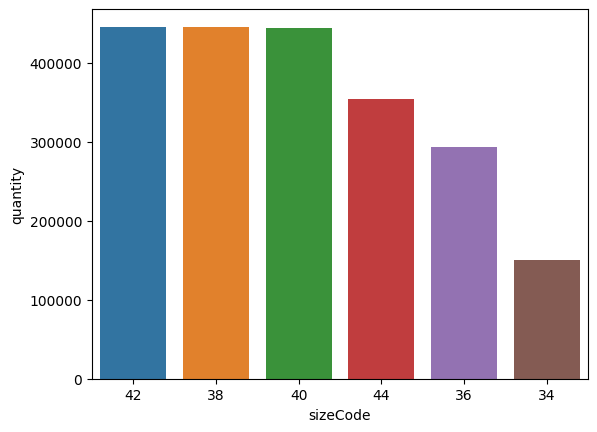

In [4]:
# dropping sizes A and I for now...
data = data[~data['sizeCode'].isin(['A', 'I'])]
# sizes bought by unique customers
custm_size = data.groupby('customerID')['sizeCode'].agg(list).reset_index()
custm_size['sizeCode'] = custm_size['sizeCode'].apply(lambda x: list(set(x)))
custm_size

#encode the data
encoder = TransactionEncoder() #initialize the encoder
ecd_data = encoder.fit(custm_size['sizeCode']).transform(custm_size['sizeCode'])# encoded data

# make dataframe of encoded data
ecd_df = pd.DataFrame(ecd_data, columns=encoder.columns_)
FP = apriori(ecd_df, min_support= 0.00005, use_colnames=True, max_len = 2)
rules = association_rules(FP, metric='confidence', min_threshold= 0.001)

rules['antecedents'] = list(map(lambda x: list(x)[0], rules['antecedents']))
rules['consequents'] = list(map(lambda x: list(x)[0], rules['consequents']))
bold = "\033[1m"
reset = "\033[0m"
print(bold+'Mapping of other units of sizes to standard sizes between 34 - 44:\n'+reset)
print(bold+'other unit\t standard unit \t confidence'+reset)
for size in ['75', '80', '85', '90', '95', '100', 'XS', 'S', 'M', 'L', 'XL', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']:
    idx = [rules[rules['antecedents'] == size]['confidence'].idxmax()]
    print(rules.iloc[idx]['antecedents'].to_string(index=False), '\t\t', rules.iloc[idx]['consequents'].to_string(index=False),
          '\t\t', rules.iloc[idx]['confidence'].to_string(index=False))


mapping = {'75':'34', '80': '36', '85': '38', '90': '38', '95': '40', '100': '42', 'XS':'34', 'S': '36',  'M': '38','L':'42',
'XL':'42', '24':'34', '25':'34' , '26':'36', '27':'36', '28':'38','29': '38','30':'40','31':'40','32':'42', '33':'42'}
for key in mapping.keys():
    idx = data['sizeCode']==key
    data.loc[idx, 'sizeCode'] = mapping[key]
# new size distribution after mapping different sizes into standard sizes
sizes = data['sizeCode'].value_counts()
sns.barplot(x= sizes.index, y=sizes.values, hue=sizes.index)
plt.ylabel('quantity')
plt.show()

del custm_size
del ecd_df

In [5]:
## extract day, month, year, weekday from orderDate column
format = '%Y-%m-%d'
data['orderDate'] = pd.to_datetime(data['orderDate'], format=format)

# Extracting components
data['day'] = data['orderDate'].dt.day
data['month'] = data['orderDate'].dt.month
data['year'] = data['orderDate'].dt.year
data['weekend'] = data['orderDate'].dt.dayofweek
data['weekend'] = data['weekend'].apply(lambda x: 0 if 0 <= x <= 4 else 1)
data.head()

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity,day,month,year,weekend
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.00,29.99,0,0.0,c1010575,2,BPRG,0,1,1,2014,0
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.00,39.99,0,0.0,c1010575,2,BPRG,0,1,1,2014,0
2,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.00,49.99,0,0.0,c1045905,4,BPRG,0,1,1,2014,0
3,a1000002,2014-01-01,i1001999,1992,38,8.0,1,49.99,49.99,0,0.0,c1045905,4,BPRG,1,1,1,2014,0
4,a1000003,2014-01-01,i1001942,1968,42,8.0,1,10.00,35.99,0,0.0,c1089295,2,PAYPALVC,0,1,1,2014,0


In [6]:
def month_to_quarter(month):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    else:
        return 4

# Apply the function to create the quarter column
data['quarter'] = data['month'].apply(month_to_quarter)

#### Voucher

In [7]:
# true price per item taking voucher into account
df= pd.DataFrame()

data['pricePerItem'] = data['price']/data['quantity']
df['totalPrice'] = data.groupby('orderID')['price'].sum()
data['totalPrice'] = data['orderID'].map(df['totalPrice'])

del df

In [8]:
data['truePricePerItem'] =  data['pricePerItem'] - data['voucherAmount']*data['pricePerItem']/data['totalPrice']
# data.head()

#### Discounts

In [9]:
# discount on products
data['discountPricePerItem'] = data['rrp']- data['pricePerItem']
data['discountRatioPerItem'] = (data['rrp']- data['pricePerItem'])/data['rrp']

#### Unique Orders

In [11]:
# order features

#total quantity of products in an order
data['quantityPerOrder'] = data['orderID'].map(data.groupby('orderID')['quantity'].sum())

# original order value
data['originalValPerOrder'] = data['rrp'] * data['quantity']
data['originalValPerOrder'] = data.groupby('orderID')['originalValPerOrder'].transform('sum')


# average order value
data['avgOrderValue'] = data['totalPrice']/ data['quantityPerOrder']

# number of different product groups per order
data['productGroupsPerOrder']= data.groupby('orderID')['productGroup'].transform('nunique')

# number of different sizes per order
data['sizesPerOrder']= data.groupby('orderID')['sizeCode'].transform('nunique')

# number of different article per order
data['articlesPerOrder']= data['orderID'].map(data.groupby('orderID')['articleID'].nunique())

#same articleID in an order
df = (data.groupby('orderID')['articleID'].count()> data.groupby('orderID')['articleID'].nunique()).astype(int)
data['sameArticleIDPerOrder'] = data['orderID'].map(df)

#same productGroup in an order
df = (data.groupby('orderID')['productGroup'].count()> data.groupby('orderID')['productGroup'].nunique()).astype(int)
data['sameProductGroupPerOrder'] = data['orderID'].map(df)

#same colorCode in an order
df = (data.groupby('orderID')['colorCode'].count()> data.groupby('orderID')['colorCode'].nunique()).astype(int)
data['sameColorCodePerOrder'] = data['orderID'].map(df)

#same sizeCode in an order
df = (data.groupby('orderID')['sizeCode'].count()> data.groupby('orderID')['sizeCode'].nunique()).astype(int)
data['samesizeCodePerOrder'] = data['orderID'].map(df)





# Mean recommended retail price per article
# data['mean_rrp_per_article'] = data.groupby('articleID')['rrp'].transform('mean')

# data['likelihood_of_returning'] = data.groupby('customerID')['returnQuantity'].transform('sum') / data.groupby('customerID')['quantity'].transform('sum') + 0.01* np.random.rand(data.shape[0])

del df

In [12]:
data.isna().sum()

orderID                     0
orderDate                   0
articleID                   0
colorCode                   0
sizeCode                    0
productGroup                0
quantity                    0
price                       0
rrp                         0
voucherID                   0
voucherAmount               0
customerID                  0
deviceID                    0
paymentMethod               0
returnQuantity              0
day                         0
month                       0
year                        0
weekend                     0
quarter                     0
pricePerItem                0
totalPrice                  0
truePricePerItem            0
discountPricePerItem        0
discountRatioPerItem        0
quantityPerOrder            0
originalValPerOrder         0
avgOrderValue               0
productGroupsPerOrder       0
sizesPerOrder               0
articlesPerOrder            0
sameArticleIDPerOrder       0
sameProductGroupPerOrder    0
sameColorC

#### Customer

In [13]:
## customer features
data['totalOrdersPerCustomer'] = data['customerID'].map(data.groupby('customerID')['orderID'].nunique())

data['totalProductGroupsPerCustomer'] = data['customerID'].map(data.groupby('customerID')['productGroup'].nunique())

data['sizeCodePerCustomer'] = data['customerID'].map(data.groupby('customerID')['sizeCode'].nunique())

data['totalColorCodePerCustomer'] = data['customerID'].map(data.groupby('customerID')['colorCode'].nunique())

data['totalDevicesPerCustomer'] = data['customerID'].map(data.groupby('customerID')['deviceID'].nunique())

df = data.groupby(['customerID', 'orderID'])['price'].sum().reset_index()
df = df.groupby(['customerID'])['price'].mean()
data['aveargeOrderValPerCustomer'] = data['customerID'].map(df)

df = data.groupby(['customerID', 'orderID'])['rrp'].sum().reset_index()
df = df.groupby(['customerID'])['rrp'].mean()
data['aveargeRrpPerCustomer'] = data['customerID'].map(df)

data.head()

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,...,sameProductGroupPerOrder,sameColorCodePerOrder,samesizeCodePerOrder,totalOrdersPerCustomer,totalProductGroupsPerCustomer,sizeCodePerCustomer,totalColorCodePerCustomer,totalDevicesPerCustomer,aveargeOrderValPerCustomer,aveargeRrpPerCustomer
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.00,29.99,0,...,1,0,1,2,1,1,4,1,28.50,67.98
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.00,39.99,0,...,1,0,1,2,1,1,4,1,28.50,67.98
2,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.00,49.99,0,...,1,0,1,1,1,1,2,1,84.99,99.98
3,a1000002,2014-01-01,i1001999,1992,38,8.0,1,49.99,49.99,0,...,1,0,1,1,1,1,2,1,84.99,99.98
4,a1000003,2014-01-01,i1001942,1968,42,8.0,1,10.00,35.99,0,...,1,0,1,1,1,2,4,1,60.00,151.96


In [14]:
data.isna().sum()

orderID                          0
orderDate                        0
articleID                        0
colorCode                        0
sizeCode                         0
productGroup                     0
quantity                         0
price                            0
rrp                              0
voucherID                        0
voucherAmount                    0
customerID                       0
deviceID                         0
paymentMethod                    0
returnQuantity                   0
day                              0
month                            0
year                             0
weekend                          0
quarter                          0
pricePerItem                     0
totalPrice                       0
truePricePerItem                 0
discountPricePerItem             0
discountRatioPerItem             0
quantityPerOrder                 0
originalValPerOrder              0
avgOrderValue                    0
productGroupsPerOrde

### Articles

In [17]:
# discounted price per article
df = data.groupby('articleID')['discountPricePerItem'].max()
data['MaxDiscountPricePerItem'] = data['articleID'].map(df)

del df

# minimum discounted price per article
df = data.groupby('articleID')['discountPricePerItem'].min()
data['MinDiscountPricePerItem'] = data['articleID'].map(df)

del df

# mean discounted price per article
df = data.groupby('articleID')['discountPricePerItem'].mean()
data['MeanDiscountPricePerItem'] = data['articleID'].map(df)

del df

# Section- 3 Modeling


In [18]:
# import libararies
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2132990 entries, 0 to 2325164
Data columns (total 45 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   orderID                        object        
 1   orderDate                      datetime64[ns]
 2   articleID                      object        
 3   colorCode                      int64         
 4   sizeCode                       object        
 5   productGroup                   float64       
 6   quantity                       int64         
 7   price                          float64       
 8   rrp                            float64       
 9   voucherID                      object        
 10  voucherAmount                  float64       
 11  customerID                     object        
 12  deviceID                       int64         
 13  paymentMethod                  object        
 14  returnQuantity                 int64         
 15  day                 

In [20]:
# cluster customerID into 5 categories to identify 5 types/levels of customers according 
# to their behavior, and use this categorization as a feature for predicting return quantity.
# since one-hot-encoding/label-encoding customerIDs is not a good option.


clusteringFeatures = ['customerID',  'totalOrdersPerCustomer', 'sizeCodePerCustomer','totalDevicesPerCustomer', 
                     'aveargeOrderValPerCustomer']

df = data.loc[:, clusteringFeatures]
df = df.drop_duplicates()
df

,customerID,totalOrdersPerCustomer,sizeCodePerCustomer,totalDevicesPerCustomer,aveargeOrderValPerCustomer
0,c1010575,2,1,1,28.50
2,c1045905,1,1,1,84.99
4,c1089295,1,2,1,60.00
9,c1050116,1,1,1,89.99
10,c1089296,4,3,1,106.75
...,...,...,...,...,...
2325057,c1319450,1,1,1,278.79
2325099,c1319460,1,3,1,474.91
2325138,c1319461,1,2,1,479.93
2325152,c1319457,1,1,1,129.98


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import pandas as pd

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaling', StandardScaler(), clusteringFeatures[1:])],
    remainder='passthrough')

# Apply preprocessing
df_scaled = preprocessor.fit_transform(df.iloc[:, 1:])

# Clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(df_scaled)

# Add cluster labels to the DataFrame
df['cluster'] = clusters

# Print DataFrame with cluster labels
# df



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
data= pd.merge(data, df.loc[:, ['customerID', 'cluster']], on = 'customerID')
data = data.rename(columns={'cluster': 'customerGroup'})
data.head()


,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,...,totalProductGroupsPerCustomer,sizeCodePerCustomer,totalColorCodePerCustomer,totalDevicesPerCustomer,aveargeOrderValPerCustomer,aveargeRrpPerCustomer,MaxDiscountPricePerItem,MinDiscountPricePerItem,MeanDiscountPricePerItem,customerGroup
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.0,29.99,0,...,1,1,4,1,28.50,67.98,19.99,19.99,19.990000,1
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.0,39.99,0,...,1,1,4,1,28.50,67.98,24.99,19.99,22.466415,1
2,a1155949,2014-05-27,i1000579,3974,44,3.0,1,9.0,29.99,0,...,1,1,4,1,28.50,67.98,20.99,0.00,12.644338,1
3,a1155949,2014-05-27,i1000629,1894,44,3.0,1,18.0,35.99,0,...,1,1,4,1,28.50,67.98,25.99,0.00,10.513429,1
4,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.0,49.99,0,...,1,1,2,1,84.99,99.98,34.99,14.99,23.532714,1


In [23]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Create a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot with hue
# scatter = ax.scatter(df['totalOrdersPerCustomer'], df['totalDevicesPerCustomer'], df['aveargeOrderValPerCustomer'], c=df['cluster'], cmap='viridis')

# # Customize plot
# ax.set_xlabel('Total Orders Per Customer')
# ax.set_ylabel('Size Code Per Customer')
# ax.set_zlabel('Average Order Value Per Customer')
# ax.set_title('3D Scatter plot of clusters')
# plt.legend(*scatter.legend_elements(), title='Cluster')
# plt.show()


# del df


In [24]:
from sklearn.preprocessing import OneHotEncoder

# data[['productGroup', 'deviceID',  'customerGroup']] = data[['productGroup', 'deviceID', 'customerGroup']].astype(str)
data[['productGroup', 'deviceID']] = data[['productGroup', 'deviceID']].astype(str)

# Define columns for one-hot encoding
# OHE_feats = ['productGroup', 'deviceID', 'paymentMethod', 'customerGroup']
OHE_feats = ['productGroup', 'deviceID', 'paymentMethod']
# OHE_feats = ['productGroup', 'paymentMethod']

# Perform one-hot encoding
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_features = encoder.fit_transform(data[OHE_feats])

# Create DataFrame with one-hot encoded features
df_OHE = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(OHE_feats))

# Concatenate original DataFrame with one-hot encoded DataFrame
data = data.reset_index().drop(columns={'index'})
data = pd.concat([data, df_OHE], axis=1)

# Remove one-hot encoded DataFrame
del df_OHE



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
data.isna().sum()

orderID                   0
orderDate                 0
articleID                 0
colorCode                 0
sizeCode                  0
                         ..
paymentMethod_KKE         0
paymentMethod_NN          0
paymentMethod_PAYPALVC    0
paymentMethod_RG          0
paymentMethod_VORAUS      0
Length: 73, dtype: int64

In [26]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform 'sizeCode' column
data['sizeCode'] = label_encoder.fit_transform(data['sizeCode'])

# Check the mapping of original categories to encoded labels
print("Mapping of original categories to encoded labels:")
for original_category, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_category} -> {encoded_label}")


data['colorCode_1'] = data['colorCode'].apply(lambda x: int(str(x)[0]))
data['colorCode_2'] = data['colorCode'].apply(lambda x: int(str(x)[1]))
data['colorCode_3'] = data['colorCode'].apply(lambda x: int(str(x)[2]))
data['colorCode_4'] = data['colorCode'].apply(lambda x: int(str(x)[3]))

Mapping of original categories to encoded labels:
34 -> 0
36 -> 1
38 -> 2
40 -> 3
42 -> 4
44 -> 5


In [27]:
# drop colunmns
final = data.drop(columns={'orderID', 'voucherID', 'orderDate', 'customerID', 'articleID', 'day', 'year', 'colorCode',
                          'deviceID', 'paymentMethod', 'productGroup', 'price'}) # month, price, totalPrice
final = final.drop(columns={'paymentMethod_BPPL', 'paymentMethod_CBA', 'paymentMethod_KGRG','paymentMethod_KKE','paymentMethod_NN','paymentMethod_PAYPALVC',
                           'paymentMethod_RG','paymentMethod_VORAUS', })
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132990 entries, 0 to 2132989
Data columns (total 57 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   sizeCode                       int64  
 1   quantity                       int64  
 2   rrp                            float64
 3   voucherAmount                  float64
 4   returnQuantity                 int64  
 5   month                          int32  
 6   weekend                        int64  
 7   quarter                        int64  
 8   pricePerItem                   float64
 9   totalPrice                     float64
 10  truePricePerItem               float64
 11  discountPricePerItem           float64
 12  discountRatioPerItem           float64
 13  quantityPerOrder               int64  
 14  originalValPerOrder            float64
 15  avgOrderValue                  float64
 16  productGroupsPerOrder          int64  
 17  sizesPerOrder                  int64  
 18  ar

In [28]:
final.isna().sum()

sizeCode                         0
quantity                         0
rrp                              0
voucherAmount                    0
returnQuantity                   0
month                            0
weekend                          0
quarter                          0
pricePerItem                     0
totalPrice                       0
truePricePerItem                 0
discountPricePerItem             0
discountRatioPerItem             0
quantityPerOrder                 0
originalValPerOrder              0
avgOrderValue                    0
productGroupsPerOrder            0
sizesPerOrder                    0
articlesPerOrder                 0
sameArticleIDPerOrder            0
sameProductGroupPerOrder         0
sameColorCodePerOrder            0
samesizeCodePerOrder             0
totalOrdersPerCustomer           0
totalProductGroupsPerCustomer    0
sizeCodePerCustomer              0
totalColorCodePerCustomer        0
totalDevicesPerCustomer          0
aveargeOrderValPerCu

In [29]:
y = final.pop('returnQuantity')
# y.loc[y>0] = 1
# y = y.astype(int)
X = final

In [30]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.1)
print( f"shape of X_train, y_train, X_test, y_test: {X_train.shape}, {y_train.shape},{X_test.shape},{y_test.shape}")

shape of X_train, y_train, X_test, y_test: (1919691, 56), (1919691,),(213299, 56),(213299,)


In [31]:
X.columns[19]
del X, y

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Define the columns you want to normalize
columns_to_normalize = ['rrp', 'voucherAmount', 'pricePerItem', 'truePricePerItem',
       'discountRatioPerItem', 'quantityPerOrder', 'avgOrderValue',
       'productGroupsPerOrder', 'sizesPerOrder', 'articlesPerOrder',
       'totalOrdersPerCustomer', 'sizeCodePerCustomer',
       'totalDevicesPerCustomer', 'aveargeOrderValPerCustomer', 'quantity', 'totalPrice','discountPricePerItem',
        'MaxDiscountPricePerItem', 'MinDiscountPricePerItem', 'MeanDiscountPricePerItem']#, 'likelihood_of_returning']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])


In [34]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier


In [35]:
# clf = LogisticRegression(tol=1e-15, max_iter = 1000, C = 2, penalty='l2', solver = 'lbfgs', verbose = 1, warm_start=True).fit(X_train, y_train)
# # clf = RandomForestClassifier().fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# # clf = tree.DecisionTreeClassifier(criterion = 'log_loss').fit(X_train, y_train)
# # y_pred = clf.predict(X_test)
# print('accuracy:', accuracy_score(y_test, y_pred))
# print("Precision:",precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1-score:", f1_score(y_test, y_pred))


# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot();

In [36]:
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)

# # Predicting on the test set
# y_pred = clf.predict(X_test)

# print('accuracy:', accuracy_score(y_test, y_pred))
# print("Precision:",precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1-score:", f1_score(y_test, y_pred))


# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot();

In [37]:
# from sklearn.ensemble import GradientBoostingRegressor
# gbrt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=5)

# # Fit the model to the training data
# gbrt.fit(X_train, y_train)

# # Predict on the testing data
# y_pred = gbrt.predict(X_test)

# # Evaluate the model performance
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

accuracy: 0.6758728357845091
Precision: 0.6876337184424476
Recall: 0.7282900470629249
F1-score: 0.7073781871127214


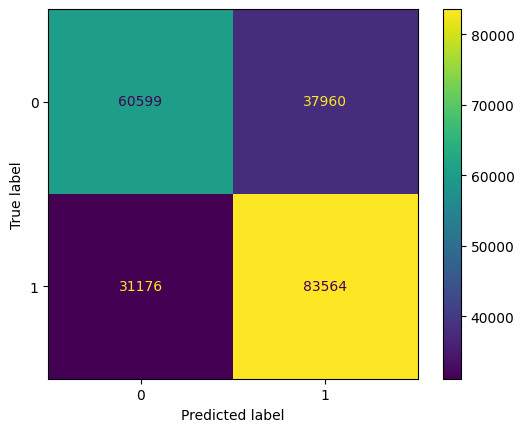

In [38]:
import xgboost
from sklearn.metrics import mean_absolute_error

xgb = xgboost.XGBClassifier( 
              subsample = 0.95, 
              colsample_bytree = 0.8,
            learning_rate=0.1,
            n_estimators=100,
              max_depth = 20,
              objective = 'binary:logistic', 
              eval_metric = 'logloss',
)

# xgb = xgboost.XGBClassifier(n_estimators=10, learning_rate=0.06, booster='gblinear', 
#                      reg_lambda=0.0001, reg_alpha=0.0001,
#                      n_jobs=-1)

# Fit the model to the training data
xgb.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb.predict(X_test)

# Evaluate the model performance
print('accuracy:', accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot();

In [39]:
accuracy_score(y_test, y_pred)

0.6758728357845091

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from xgboost import XGBClassifier


# Base models
# Regularized Logistic Regression
lr = LogisticRegression(fit_intercept=True)
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(subsample = 0.95, 
              colsample_bytree = 0.8,
            learning_rate=0.1,
            n_estimators=100,
              max_depth = 15,
              objective = 'binary:logistic', 
              eval_metric = 'logloss')
xgb.fit(X_train, y_train)

# Predict probabilities
lr_probs = lr.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
gb_probs = gb.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Stack predictions
stacked_features = np.column_stack((lr_probs, rf_probs, gb_probs, xgb_probs))

# Second layer model (using XGBoost for stacking)
second_layer_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
second_layer_model.fit(stacked_features, y_test)

# Predict final output
final_predictions = second_layer_model.predict_proba(stacked_features)[:, 1]

# Calculate log loss
final_log_loss = log_loss(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_mse = mean_squared_error(y_test, final_predictions)
print(f'Mean Absolute Error: {final_mae}')
print(f'Mean Squared Error: {final_mse}')
print(f'Final Log Loss: {final_log_loss}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean Absolute Error: 0.3969829373303994
Mean Squared Error: 0.19568761420460076
Final Log Loss: 0.5724637711566833


In [44]:
print('accuracy:', accuracy_score(y_test, np.round(final_predictions)))
print("Precision:",precision_score(y_test, np.round(final_predictions)))
print("Recall:", recall_score(y_test, np.round(final_predictions)))
print("F1-score:", f1_score(y_test, np.round(final_predictions)))

accuracy: 0.6975466364117975
Precision: 0.6943182785382122
Recall: 0.7820550810528151
F1-score: 0.7355797015316893


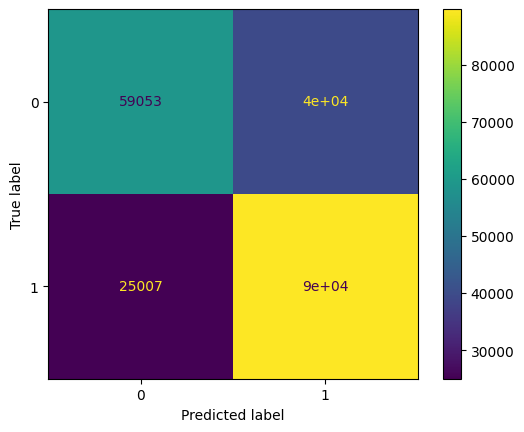

In [53]:
cm = confusion_matrix(y_test, np.round(final_predictions), labels=second_layer_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=second_layer_model.classes_)
disp.plot();

In [54]:
mean_absolute_error(y_test, np.round(final_predictions))

0.30245336358820246